# Identifying Particles

Import necessary python libraries

In [1]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

In [2]:
import deeptrack as dt
import keras
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# Set seeds
random.seed(14)
np.random.seed(0)

print("Import Complete")

Import Complete


## Loading in Images
Graph images, verify that the gold-standard center is accurate enough

In [3]:
# # Load in single image
# img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/image1.jpg')

# # Convert to DeepTrack 2.0 Feature
# img_data = dt.features.Dataset(img_data)
# output_image = img_data.resolve()

# # Display image
# plt.imshow(output_image)

# # Load in Labels
# dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/csv/data.csv')
# dataset = np.array(dataset)

# dataset = dataset / 2.0 - 1
# print(dataset[:, 0:5])

# label = dataset[0]
# print(label)

# # Plot single image against label position
# plt.imshow(np.squeeze(output_image), cmap='gray')
# plt.scatter(label[1], label[0], c="r", marker="x") # 1-indexed, compensate with -1
# plt.show()

In [4]:
# Constants
NUM_OF_IMAGES = 1000 # size of input
TEST_SIZE = 0.2      # % of dataset to be used for testing
SHUFFLE_ON = False   # shuffle training/testing set
EPSILON = 1.0        # 

In [5]:
# # ==========================================
# # Load in all images
# all_images = []
# for i in range(0, NUM_OF_IMAGES):
#     image_name = 'image' + str(i + 1) + '.jpg'
#     img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/' + image_name)
#     all_images.append(img_data)

# print("Finished loading all images")

# img_data = all_images[0]
# img_data = dt.features.Dataset(img_data)
# output_image = img_data.resolve()
# plt.imshow(np.squeeze(output_image), cmap='gray')

# # Load in Labels
# dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/csv/data.csv')
# dataset = np.array(dataset, dtype="float64")
# dataset = dataset / 2.0 - 1 # div 2 for fractional units, -1 to offset MATLAB 1-index

# # ==========================================
# # Sample a few points to show the true label
# chosen = [0, 6, 266, 977]
# for i in chosen:
#     # Select image plot
#     img_data = all_images[i]
#     img_data = dt.features.Dataset(img_data)
#     output_image = img_data.resolve()
    
#     # Display image grayscale
#     plt.imshow(np.squeeze(output_image), cmap='gray')
    
#     # Load in label for selected data
#     label = dataset[i]
#     print(label)

#     # Show image with true label
# #     plt.imshow(np.squeeze(output_image), cmap='gray')
# #     plt.scatter(label[1], label[0], c="r", marker="x") # 1-indexed, compensate with -1
# #     plt.show()
# original_all_images = all_images.copy()



(1000, 101, 101)


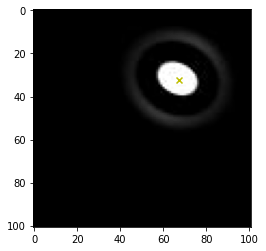

In [6]:
max_width = 101
# Load in Labels
dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/csv/data.csv')
dataset = np.array(dataset, dtype="float64")
dataset = dataset / 2.0
new_all_images = [] # 57x57
# random range is 0-44

old_label = []
for i in range(1, 1001):
    img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/image' + str(i) + '.jpg')
    # print(img_data)
    C = img_data[22:-22, 22:-22]
# print(C)
    rand_x = random.randint(0, 44)
    rand_y = random.randint(0, 44)
    
    D = np.pad(C, ((rand_x, max_width - 57 - rand_x), (rand_y, max_width - 57 - rand_y)), 'constant')
#     print("Old coordinates were ", dataset[0], "Change by", rand_x, rand_y)
    old_label = dataset[0].copy()
    dataset[i - 1] = [dataset[i - 1][0] - 22 + rand_x, dataset[i - 1][1] - 22 + rand_y, dataset[i - 1][2]]
#     print("New coordinates are ", dataset[0])
    
    new_all_images.append(D)
#     plt.imshow(np.squeeze(D), cmap='gray')
#     plt.show()
    
new_all_images = np.array(new_all_images)
print(new_all_images.shape)
# print(new_all_images.shape)
plt.imshow(np.squeeze(new_all_images[0]), cmap='gray')
label = dataset[0]
plt.scatter(label[1], label[0], c="y", marker="x") # 1-indexed, compensate with -1
# plt.scatter(old_label[1] - 1, old_label[0] - 1, c="g", marker="x") # 1-indexed, compensate with -1
plt.show()

In [7]:
# # The generator part
# for i in range(0, len(all_images)):
#     img_data = all_images[i] #all_images[0]
#     label = dataset[i]
#     img_data = dt.features.Dataset(img_data)
#     img_data.properties.setdefault('position', [label[1] - 1, label[0] - 1])
#     # print(img_data.properties)
#     all_images[0] = img_data
# all_images = np.array(all_images)

## Training NN
It seems like the labels can only be a single value, so the way it is currently working on it, is to have a separate CNN for x- and y- labels. When combined, they will give the center position attribute for the cell.

In [8]:
x_model = dt.models.convolutional(
    input_shape=(101, 101, 1), 
    conv_layers_dimensions=(1,),
#     dense_top=False,
    activation_function="relu", # flatten it too (? maybe use standard keras here)
    number_of_outputs=1,
    loss='mean_absolute_error',
    optimiser='adam',
    metrics=['accuracy'],
    output_activation="linear",
)

print("Model summary:")
x_model.summary()

Model summary:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 101, 101, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 101, 101, 1)       10        
_________________________________________________________________
activation (Activation)      (None, 101, 101, 1)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 51, 51, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2601)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                83264     
_________________________________________________________________
activation_1 (Activation)    (None, 32)       

In [9]:

X_train, X_test, Y_train, Y_test = train_test_split(new_all_images, dataset, test_size=TEST_SIZE, shuffle=SHUFFLE_ON)

# Labels into individual sets.
train_x_labels = np.zeros(800)
train_y_labels = np.zeros(800)

test_x_labels = np.zeros(200)
test_y_labels = np.zeros(200)

# Split by x, y coordinates
count = 0
for elem in Y_train:
    train_x_labels[count] = elem[0]
    train_y_labels[count] = elem[1]
    count += 1

count = 0
for elem in Y_test:
    test_x_labels[count] = elem[0]
    test_y_labels[count] = elem[1]
    count += 1

# X_train, X_test, Y_x_train, Y_x_test = train_test_split(new_all_images, x_dataset, shuffle=False)

# # Data
all_images = tf.convert_to_tensor(new_all_images)
train_images = tf.convert_to_tensor(X_train)


# # x-coordinate position labels
# x_dataset = tf.convert_to_tensor(x_dataset)
train_x_labels = tf.convert_to_tensor(train_x_labels)

In [10]:
y_model = dt.models.convolutional(
    input_shape=(101, 101, 1), 
    conv_layers_dimensions=(1,),
#     dense_top=False,
    activation_function="relu", # flatten it too (? maybe use standard keras here)
    number_of_outputs=1,
    loss='mean_absolute_error',
    optimiser='adam',
    metrics=['accuracy'],
    output_activation="linear",
)

print("Model summary:")
y_model.summary()

Model summary:
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 101, 101, 1)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 101, 101, 1)       10        
_________________________________________________________________
activation_3 (Activation)    (None, 101, 101, 1)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 51, 51, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2601)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                83264     
_________________________________________________________________
activation_4 (Activation)    (None, 32)     

In [11]:
print("Fitting the model")
history = x_model.fit(
    x=train_images,
    y=train_x_labels,
    epochs=500,
    validation_split=0.4,
    verbose=0,
)

print("Model finished fitting")

Fitting the model
Model finished fitting


In [12]:
print("Fitting the model")
history = y_model.fit(
    x=train_images,
    y=train_y_labels,
    epochs=500,
    validation_split=0.4,
    verbose=0,
)

print("Model finished fitting")

Fitting the model
Model finished fitting


X-Coordinate
Training Accuracy:  54.50000000000001 %
Test Accuracy 47.0 %
Y-Coordinate
Training Accuracy:  3.75 %
Test Accuracy 2.5 %


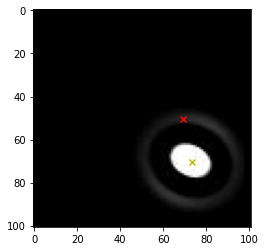

In [13]:
def accuracy_prediction(model, train_images, test_images, train_labels, test_labels, train_acc=True):
    if train_acc:
        predicted = np.array(model.predict_on_batch(train_images))
        train_labels = tf.convert_to_tensor(train_labels)

        count = 0
        for i in range(0, len(train_labels)):
            difference = round(round(predicted[i][0], 1) - float(train_labels[i]), 2)
            if abs(difference) <= EPSILON:
                count += 1

        print("Training Accuracy: ", count / len(train_labels) * 100, "%")

    # 357 correct within 0.5
    # 613 correct within 1.0

    # ========
    test_images = tf.convert_to_tensor(X_test)
    test_labels = tf.convert_to_tensor(test_labels)

    predicted = np.array(model.predict_on_batch(test_images))
    
    count = 0
    for i in range(0, len(test_labels)):
        difference = round(round(predicted[i][0], 1) - float(test_labels[i]), 2)
        if abs(difference) <= EPSILON:
            count += 1
    test_accuracy_percent = count / len(test_labels) * 100
    print("Test Accuracy", test_accuracy_percent, "%")
    return test_accuracy_percent

print("X-Coordinate")
accuracy_prediction(x_model, X_train, X_test, train_x_labels, test_x_labels)
print("Y-Coordinate")
accuracy_prediction(y_model, X_train, X_test, train_y_labels, test_y_labels)

index = 1
plt.imshow(np.squeeze(X_train[index]), cmap='gray')
plt.scatter(train_y_labels[index], train_x_labels[index], c="y", marker="x") # 1-indexed, compensate with -1
x_predicted = np.array(x_model.predict_on_batch(train_images))
y_predicted = np.array(y_model.predict_on_batch(train_images))
plt.scatter(x_predicted[index], y_predicted[index], c="r", marker="x") # 1-indexed, compensate with -1
plt.show()


In [14]:
# print(set(np.array(x_dataset)))

Final loss: 10.544
Final accuracy: 0.0
Final val_loss: 11.535
Final val_accuracy: 0.0


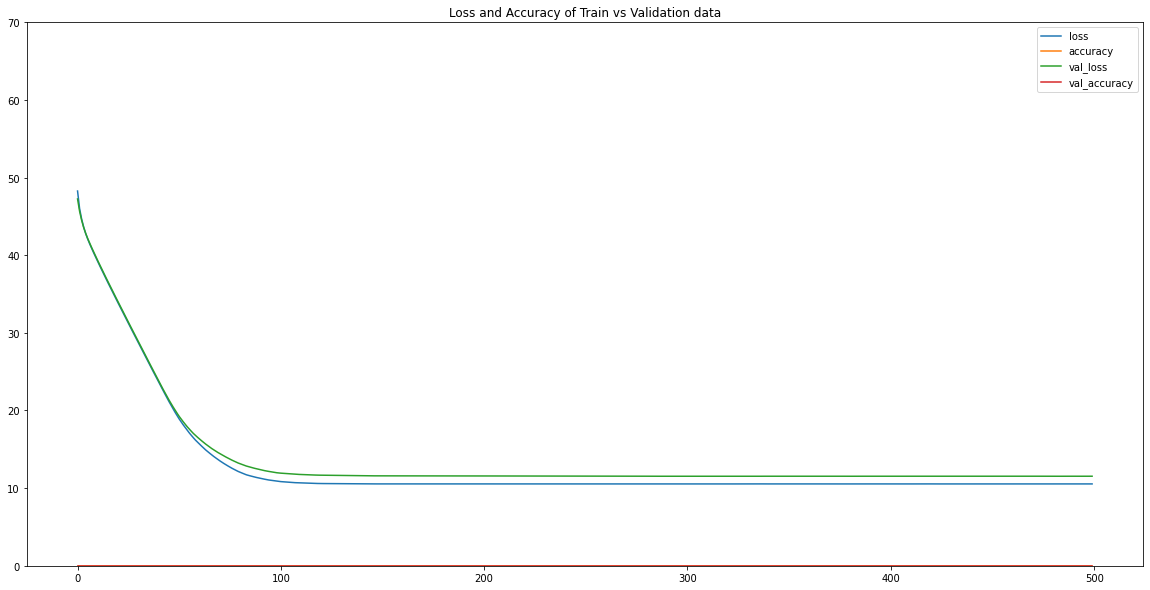

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [15]:
def plot_history(history, ylim=70): # Thank you catkins
    """
    Plot train and validation accuracy and loss in one chart.
    :param history: The dictionary containing the accuracy and loss history.
    """
    keep = ""
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Loss and Accuracy of Train vs Validation data')
    for key, value in history.history.items():
        ax.plot(value, label=key)
        print(f'Final {key}: {round(value[-1], 3)}')
        if key == "accuracy":
            keep = value
    plt.ylim([0,ylim])
    ax.legend()
    plt.show()
    return keep
plot_history(history)

In [16]:
# y_model = dt.models.convolutional(
#     input_shape=(101, 101, 1), 
#     number_of_outputs=1,
#     loss='mean_absolute_error',
#     optimiser='adam',
#     metrics=['mean_absolute_error', 'accuracy']
# )

# print("Model summary:")
# y_model.summary()

# print("Fitting the model")
# history = y_model.fit(
#     x=all_images,
#     y=y_dataset,
#     epochs=30,
#     validation_split=0.4
# )

# print("Model finished fitting")

In [17]:
# y_predicted = y_model.predict_on_batch(all_images)
# print(y_predicted)
# print(y_dataset)